In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("mps")
device

device(type='mps')

In [2]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [3]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


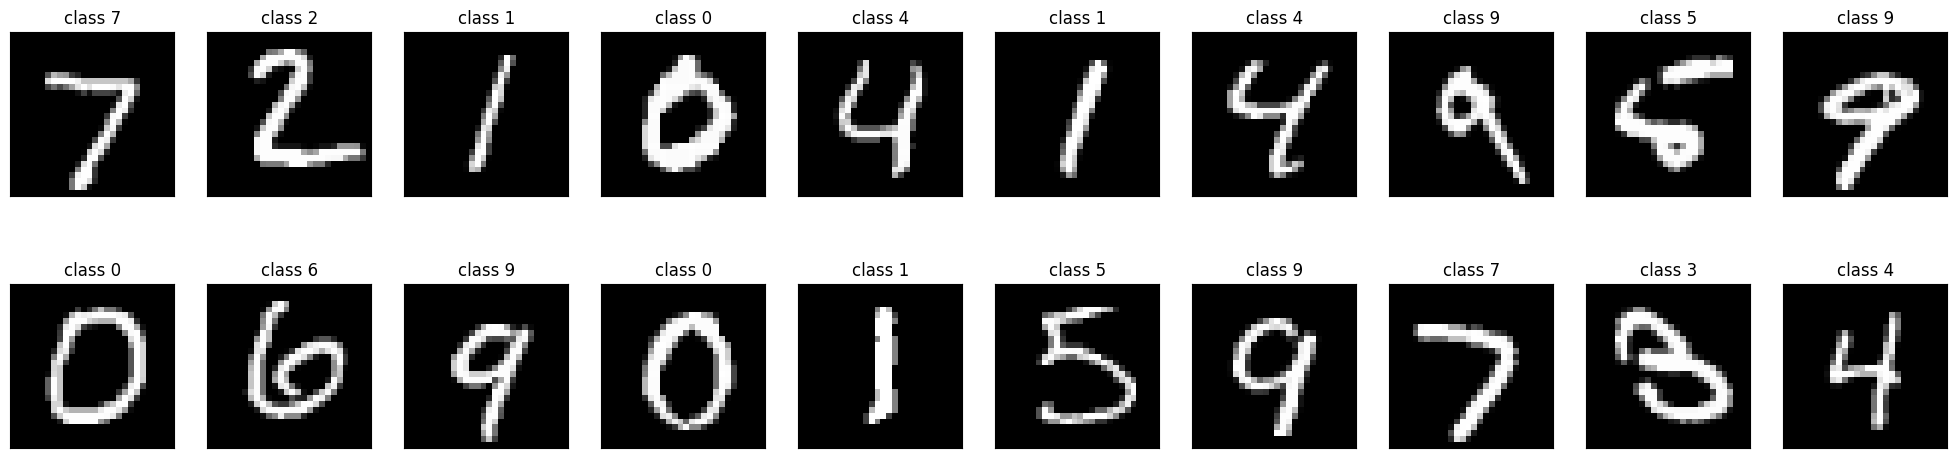

In [4]:
plt.figure(figsize=(25, 6))

for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i + 1)
    plt.imshow(x.view(28, 28), cmap='gray')
    plt.title(f"class {y}")
    plt.xticks([])
    plt.yticks([])

In [5]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(H, D_out)
        )
    
    def forward(self, x):
        return self.fc(x)

In [8]:
input_dim = 28 * 28
hidden_dim = 128
output_dim = 10

model = Net(input_dim, hidden_dim, output_dim)

In [9]:
for k, v in model.state_dict().items():
    print(k, v.numel())

fc.0.weight 100352
fc.0.bias 128
fc.3.weight 16384
fc.3.bias 128
fc.6.weight 1280
fc.6.bias 10


In [10]:
criterion = nn.CrossEntropyLoss()
model.to(device)

Net(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [11]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [12]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_acc = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x.view(-1, 28 * 28))
        loss = criterion(z, y)
        train_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        train_acc += (y_pred == y).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = (train_loss * 100) / (len(train_loader) * batch_size)
    train_acc = (train_acc * 100) / (len(train_loader) * batch_size)
    LOSS.append(train_loss)
    ACC.append(train_acc)
    
    model.eval()
    
    val_loss = 0
    val_acc = 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)

        z = model(x.view(-1, 28 * 28))
        loss = criterion(z, y)
        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item()

    val_loss = (val_loss * 100) / (len(valid_loader) * batch_size)
    val_acc = (val_acc * 100) / (len(valid_loader) * batch_size)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)
    
    print(f"epoch {epoch + 1} ==> train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, train acc: {train_acc:.5f}, val acc: {val_acc:.5f}")

epoch 0 ==> train loss: 1.73899, val loss: 1.61828, train acc: 35.90625, val acc: 62.19249
epoch 1 ==> train loss: 1.31360, val loss: 0.91576, train acc: 60.16875, val acc: 74.01928
epoch 2 ==> train loss: 0.77181, val loss: 0.55327, train acc: 71.74583, val acc: 81.60738
epoch 3 ==> train loss: 0.56462, val loss: 0.42037, train acc: 78.35625, val acc: 85.22274
epoch 4 ==> train loss: 0.47018, val loss: 0.35597, train acc: 82.00625, val acc: 87.20911
epoch 5 ==> train loss: 0.41594, val loss: 0.31875, train acc: 84.52292, val acc: 88.37267
epoch 6 ==> train loss: 0.38337, val loss: 0.29585, train acc: 85.65417, val acc: 88.92121
epoch 7 ==> train loss: 0.35655, val loss: 0.27698, train acc: 86.65625, val acc: 89.71077
epoch 8 ==> train loss: 0.33485, val loss: 0.26353, train acc: 87.55833, val acc: 90.10140
epoch 9 ==> train loss: 0.32134, val loss: 0.25169, train acc: 87.95208, val acc: 90.48371
epoch 10 ==> train loss: 0.30490, val loss: 0.24191, train acc: 88.70625, val acc: 90.7081

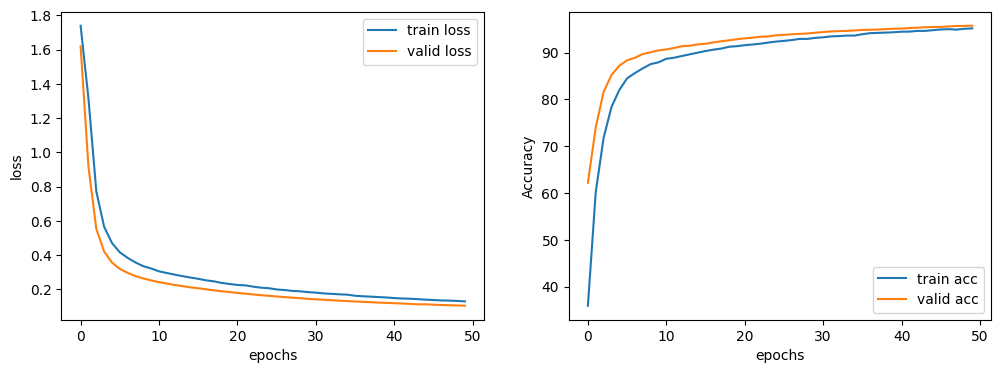

In [15]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='valid loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(ACC, label='train acc')
ax2.plot(VAL_ACC, label='valid acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [16]:
predictions = []
labels = []

model.eval()
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x.view(-1, 28 * 28))
    _, y_pred = torch.max(z, 1)
    
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

print(len(correct_indices) * 100 / len(predictions))

96.05


In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, predictions)

array([[ 968,    0,    1,    1,    0,    3,    4,    2,    1,    0],
       [   0, 1120,    2,    2,    0,    1,    3,    2,    5,    0],
       [  10,    1,  985,    8,    6,    0,    6,    8,    7,    1],
       [   1,    0,   15,  965,    0,    7,    0,   11,    9,    2],
       [   2,    0,    4,    0,  941,    0,    7,    2,    4,   22],
       [   6,    1,    0,   11,    3,  843,   11,    2,    8,    7],
       [  10,    3,    0,    1,    6,    7,  927,    0,    4,    0],
       [   3,   13,   13,    2,    3,    0,    0,  984,    0,   10],
       [   4,    3,    3,   11,    4,    7,    8,    7,  923,    4],
       [   7,    6,    0,   12,   16,    8,    1,    9,    1,  949]])